In [1]:
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
import albumentations as alb
from PIL import Image
import numpy as np
import skimage
import math
import glob
import os

In [2]:
# Avoid out of memory errors
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [56]:
image_paths1 = os.listdir("images/images/")
anchor_paths = os.listdir("images/anchor/")
repeated_faces = []

for path in image_paths1:
    if len(os.listdir(f"images/images/{path}/")) > 1:
        repeated_faces.append(path)

In [57]:
HEIGHT = 120
WIDTH = 120

In [58]:
def get_image(file):
    byte_img = tf.io.read_file(file)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (HEIGHT, WIDTH))
    return img / 255.0

x = []
anchors = []

for person in repeated_faces:
    faces = os.listdir(f"images/images/{person}/")
    temp = []
    for face in faces:
        temp.append(get_image(f"images/images/{person}/{face}"))
    x.append(temp)
    
for anchor in anchor_paths:
    anchors.append(get_image(f"images/anchor/{anchor}"))

In [59]:
len(x)

1680

In [60]:
len(anchors)

1741

In [61]:
x_train, x_test = x[:1400], x[1400:]
anchors_train, anchors_test = anchors[:1500], anchors[1500:]

In [62]:
def augmentor(img):
    img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
    img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
    img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
    img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
    img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
    return img

In [63]:
def get_batch1(batch_size, validation=False):
    x = x_train
    if validation:
        x = x_test
    batch_x = []
    
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(0, len(x), batch_size)
    batch_x.append(np.zeros((batch_size, HEIGHT, WIDTH, 3)))
    batch_x.append(np.zeros((batch_size, HEIGHT, WIDTH, 3)))
    
    for i in range(0, batch_size):
        person = x[np.random.choice(len(x))]
        batch_x[0][i] = person[np.random.choice(len(person))]
        batch_x[0][i] = augmentor(batch_x[0][i])
        
        # Same
        if batch_y[i] == 0:
            batch_x[1][i] = person[np.random.choice(len(person))]
            
        # Different
        if batch_y[i] == 1:
            new_person = x[np.random.choice(len(x))]
            while np.array_equal(new_person, person):
                new_person = x[np.random.choice(len(x))]
            batch_x[1][i] = new_person[np.random.choice(len(new_person))]
            batch_x[1][i] = augmentor(batch_x[1][i])
            
    return (batch_x, batch_y)

In [64]:
def get_batch2(batch_size, validation=False):
    anchor = anchors_train
    x = x_train
    if validation:
        anchor = anchors_test
        x = x_test
    batch_x = []
    
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(0, len(x), batch_size)
    batch_x.append(np.zeros((batch_size, HEIGHT, WIDTH, 3)))
    batch_x.append(np.zeros((batch_size, HEIGHT, WIDTH, 3)))
    
    for i in range(0, batch_size):
        batch_x[0][i] = anchor[np.random.choice(len(anchor))]
        batch_x[0][i] = augmentor(batch_x[0][i])
        
        # Same
        if batch_y[i] == 0:
            batch_x[1][i] = anchor[np.random.choice(len(anchor))]
            
        # Different
        if batch_y[i] == 1:
            person = x[np.random.choice(len(x))]
            batch_x[1][i] = person[np.random.choice(len(person))]
            batch_x[1][i] = augmentor(batch_x[1][i])
            
    return (batch_x, batch_y)

In [65]:
batch = get_batch2(16)

In [66]:
batch[1]

array([1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.])

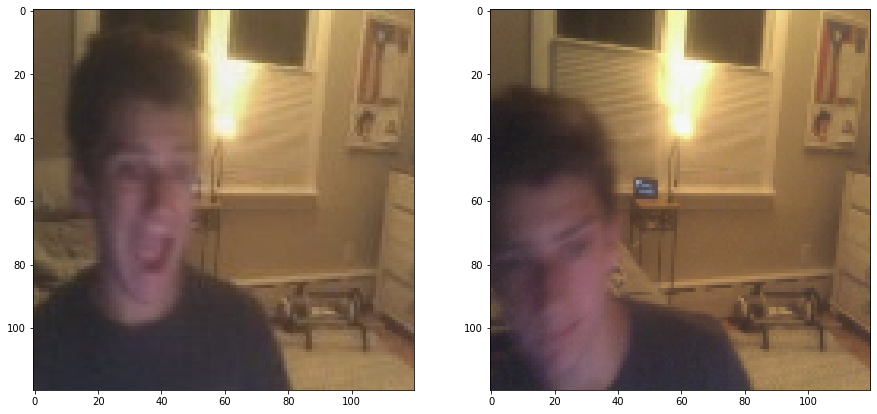

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))
axes[0].imshow(batch[0][0][3])
axes[1].imshow(batch[0][1][3])

# Create Model

In [68]:
def create_pretrained_model():
    input_1 = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
    input_2 = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
    
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    
    x1 = base_model(input_1)
    x1 = tf.keras.layers.GlobalMaxPooling2D()(x1)
    x1 = tf.keras.layers.Dense(256, activation="relu")(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    x1 = tf.keras.layers.Dense(1024, activation="relu")(x1)
    
    x2 = base_model(input_2)
    x2 = tf.keras.layers.GlobalMaxPooling2D()(x2)
    x2 = tf.keras.layers.Dense(256, activation="relu")(x2)
    x2 = tf.keras.layers.Dropout(0.5)(x2)
    x2 = tf.keras.layers.Dense(1024, activation="relu")(x2)

    diff = tf.keras.layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([x1, x2])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(diff)
    
    siamese_model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)
    return siamese_model

In [69]:
#siamese_model = create_siamese_model()
siamese_model = create_pretrained_model()

In [70]:
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

In [71]:
siamese_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_8 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg19 (Functional)             (None, None, None,   20024384    ['input_7[0][0]',                
                                512)                              'input_8[0][0]']          

In [72]:
def plot_loss():
    # Plotting
    losses = [x for x in loss_list]
    val_losses = [x for x in val_loss_list]
    accuracies = [x for x in accuracy_list]
    val_accuracies = [x for x in val_accuracy_list]

    f, axs = plt.subplots(2, 2, figsize=(15,5))
    clear_output(wait=True)

    axs[0][0].plot(losses, label="loss")
    axs[1][0].plot(accuracies, label="accuracy", color="orange")
    axs[0][1].plot(val_losses, label="val loss")
    axs[1][1].plot(val_accuracies, label="val accuracy", color="orange")
    plt.ylim([0, 1])

    axs[0][0].legend()
    axs[0][0].grid()
    axs[0][1].legend()
    axs[0][1].grid()
    axs[1][0].legend()
    axs[1][0].grid()
    axs[1][1].legend()
    axs[1][1].grid()

    plt.tight_layout()
    print("Loss: ", loss_list[-1], "        Validation loss: ", val_loss_list[-1])
    print("Accuracy: ", accuracy_list[-1], " "*(len(str(loss_list[-1])) - len(str(accuracy_list[-1]))), 
                                               "   Validation accuracy: ", val_accuracy_list[-1])
    plt.show()

Loss:  0.009729407727718353         Validation loss:  0.10873862355947495
Accuracy:  1.0                      Validation accuracy:  0.953125


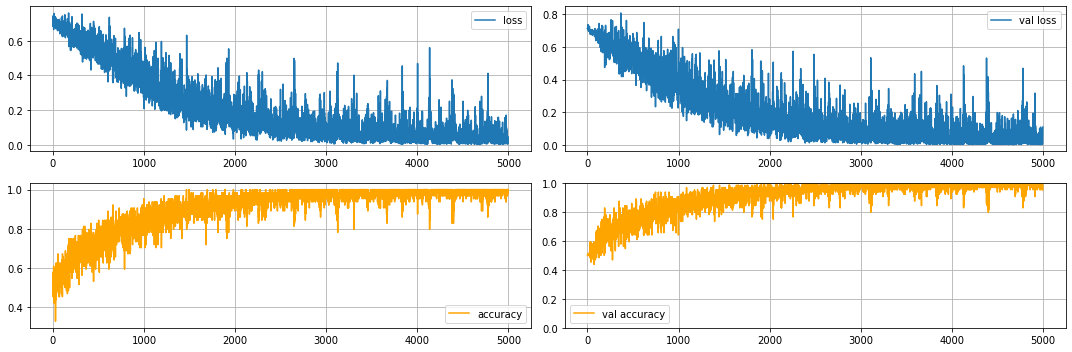

In [74]:
EPOCHS = 5000
BATCH_SIZE = 64

loss_list = []
val_loss_list = []
accuracy_list = []
val_accuracy_list = []

for epoch in range(1, EPOCHS+1):
#     if np.random.randint(4):
#         batch_x, batch_y = get_batch1(BATCH_SIZE)
#     else:
    batch_x, batch_y = get_batch1(BATCH_SIZE)
        
    loss, accuracy = siamese_model.train_on_batch(batch_x, batch_y)
    loss_list.append(loss)
    accuracy_list.append(accuracy)
    print("Epoch: ", epoch, ", Loss: ", loss, ", Acc:", accuracy)
    batch_x_val, batch_y_val = get_batch1(BATCH_SIZE)
    val_loss, val_accuracy = siamese_model.evaluate(batch_x_val, batch_y_val, verbose=0)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_accuracy)
    if epoch % 10 == 0:
        plot_loss()

#os.system("rundll32.exe powrprof.dll,SetSuspendState 0,1,0")

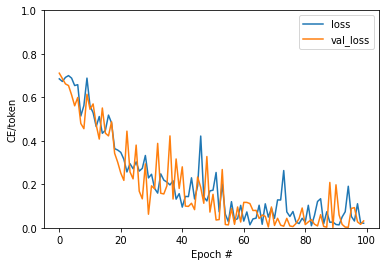

In [75]:
plt.plot([loss_list[i] for i in range(0, len(loss_list), 50)], label='loss')
plt.plot([val_loss_list[i] for i in range(0, len(val_loss_list), 50)], label='val_loss')
plt.ylim([0, 1])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [85]:
siamese_model.predict([np.expand_dims(get_image("images/Nathan1.jpeg"), axis=0),
                       np.expand_dims(get_image("images/Tito.jpg"), axis=0)])

1/1 [==============================] - 0s 18ms/step


array([[0.99997187]], dtype=float32)

# Save to TFLite

In [82]:
siamese_model.save("face_verification")

INFO:tensorflow:Assets written to: face_verification\assets


INFO:tensorflow:Assets written to: face_verification\assets


In [157]:
model = tf.keras.models.load_model("siamese_model")

In [83]:
model.predict([np.expand_dims(get_image("images/Nathan1.jpeg"), axis=0),
               np.expand_dims(get_image("images/Tito.jpeg"), axis=0)])

NameError: name 'model' is not defined

In [92]:
converter = tf.lite.TFLiteConverter.from_saved_model("siamese_model")
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [93]:
interpreter = tf.lite.Interpreter("model.tflite")
my_signature = interpreter.get_signature_runner()

In [ ]:
my_signature()

In [108]:
output = my_signature(input_15=tf.cast(np.expand_dims(get_image(BASE_PATH + "/images/Jamie.jpeg"), axis=0), tf.float32),
                      input_16=tf.cast(np.expand_dims(get_image(BASE_PATH + "/images/Nathan2.jpeg"), axis=0), tf.float32))

In [109]:
output

{'dense_15': array([[0.5747471]], dtype=float32)}